In [1]:
import pyrootutils
import sys

root = pyrootutils.setup_root(
    search_from=sys.path[0],
    pythonpath=True,
    cwd=True,
)

import torch
from core_utils import main
from core_utils.utils import data_handling, train, test, gradcam, helpers, augmentation
from core_utils.models import resnet, s8_custom_resnet
from pprint import pprint
from torch_lr_finder import LRFinder


import timm
import urllib
import torch
import os
import numpy as np

import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image

from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt

## Import Config

In [2]:
config_file_path = "core_utils/config/s8_config.yaml"

config = helpers.load_config_variables(config_file_path)

 Loading config ..
 Config succesfully loaded 


## Perform GPU Check; Create "Device"

In [3]:
device, cuda = helpers.gpu_check(seed_value = 1)
pprint(device)

CUDA is available
device(type='cuda')


## Download Dataset, Create Data Loaders

In [6]:
mean, std = data_handling.return_dataset_statistics()
trainloader, testloader = main.create_dataloaders(mean, std, cuda, config, gpu_batch_size = 512, augment_func = "s8_albumentation_augmentation")

Files already downloaded and verified


/home/shivam13juna/Documents/virtual_envs/cap/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


## Model Summary

In [7]:
from torchsummary import summary
model = s8_custom_resnet.Custom_ResNet().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.04E-02


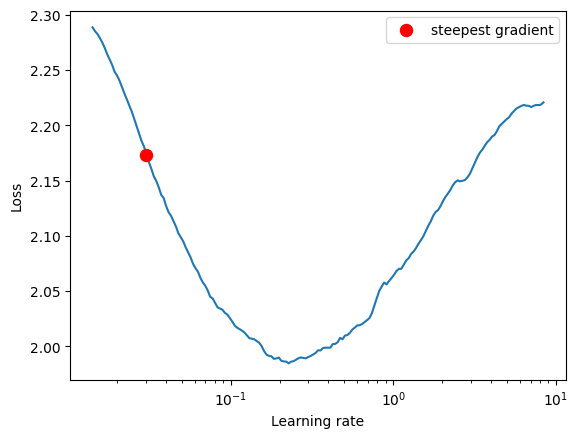

(<AxesSubplot: xlabel='Learning rate', ylabel='Loss'>, 0.030367711180354584)

In [13]:
model = s8_custom_resnet.Custom_ResNet().to(device)
# make trainloader iterator
import torchvision

# create train_loader from torchvision datasets cifar10
transform_train = T.Compose([
     T.ToTensor(),
    T.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
   
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

new_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(new_trainloader, end_lr=10, num_iter=200)
lr_finder.plot() 

LR suggestion: steepest gradient
Suggested LR: 2.15E-02


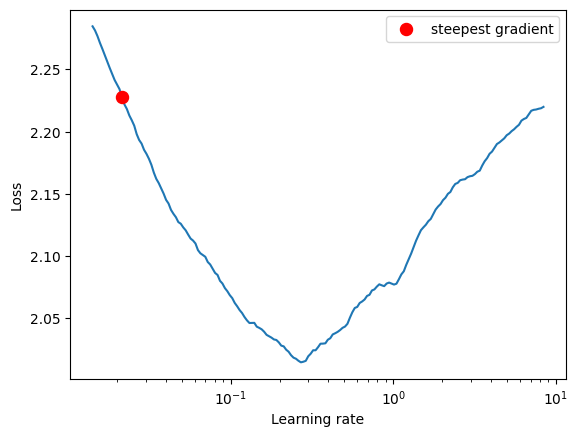

IndexError: tuple index out of range

In [11]:
0.021, 0.031

## Trigger Training

In [13]:
train_acc, train_losses, test_acc, test_losses, lrs = main.start_training(model, device, trainloader, testloader, config, optimizer_name = "Adam", scheduler_name = "ReduceLROnPlateau", criterion_name = "CrossEntropyLoss",  epochs = 50)

EPOCH: 1


Loss=2.321269989013672 Batch_id=97 LR=0.01930 Accuracy=9.79: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s] 



Test set: Average loss: 0.0047, Accuracy: 1000/10000 (10.00%)

EPOCH: 2


Loss=2.368889093399048 Batch_id=97 LR=0.01930 Accuracy=10.00: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.0047, Accuracy: 1000/10000 (10.00%)

EPOCH: 3


Loss=2.3577213287353516 Batch_id=97 LR=0.01930 Accuracy=9.98: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]



Test set: Average loss: 0.0047, Accuracy: 1000/10000 (10.00%)

EPOCH: 4


Loss=2.2839508056640625 Batch_id=97 LR=0.01930 Accuracy=15.97: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]



Test set: Average loss: 0.0046, Accuracy: 1774/10000 (17.74%)

EPOCH: 5


Loss=2.2657604217529297 Batch_id=97 LR=0.01930 Accuracy=17.85: 100%|██████████| 98/98 [00:35<00:00,  2.73it/s]



Test set: Average loss: 0.0046, Accuracy: 1759/10000 (17.59%)

EPOCH: 6


Loss=2.261789321899414 Batch_id=97 LR=0.01930 Accuracy=18.48: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s] 



Test set: Average loss: 0.0045, Accuracy: 1942/10000 (19.42%)

EPOCH: 7


Loss=2.2723705768585205 Batch_id=97 LR=0.01930 Accuracy=19.43: 100%|██████████| 98/98 [00:54<00:00,  1.80it/s]



Test set: Average loss: 0.0045, Accuracy: 2042/10000 (20.42%)

EPOCH: 8


Loss=2.2311177253723145 Batch_id=97 LR=0.01930 Accuracy=19.61: 100%|██████████| 98/98 [01:02<00:00,  1.57it/s]



Test set: Average loss: 0.0045, Accuracy: 2051/10000 (20.51%)

EPOCH: 9


Loss=2.279047727584839 Batch_id=97 LR=0.01930 Accuracy=20.11: 100%|██████████| 98/98 [01:04<00:00,  1.52it/s] 



Test set: Average loss: 0.0046, Accuracy: 1519/10000 (15.19%)

EPOCH: 10


Loss=2.2160627841949463 Batch_id=97 LR=0.01930 Accuracy=20.39: 100%|██████████| 98/98 [01:09<00:00,  1.42it/s]



Test set: Average loss: 0.0046, Accuracy: 1824/10000 (18.24%)

EPOCH: 11


Loss=2.286649703979492 Batch_id=97 LR=0.01930 Accuracy=21.11: 100%|██████████| 98/98 [01:10<00:00,  1.39it/s] 



Test set: Average loss: 0.0045, Accuracy: 1968/10000 (19.68%)

EPOCH: 12


Loss=2.2648587226867676 Batch_id=97 LR=0.01930 Accuracy=21.87: 100%|██████████| 98/98 [01:12<00:00,  1.36it/s]



Test set: Average loss: 0.0045, Accuracy: 2141/10000 (21.41%)

EPOCH: 13


Loss=2.268346071243286 Batch_id=97 LR=0.01930 Accuracy=22.60: 100%|██████████| 98/98 [01:12<00:00,  1.35it/s] 



Test set: Average loss: 0.0044, Accuracy: 2460/10000 (24.60%)

EPOCH: 14


Loss=2.2195234298706055 Batch_id=97 LR=0.01930 Accuracy=24.38: 100%|██████████| 98/98 [01:14<00:00,  1.32it/s]



Test set: Average loss: 0.0044, Accuracy: 2547/10000 (25.47%)

EPOCH: 15


Loss=2.2169511318206787 Batch_id=97 LR=0.01930 Accuracy=25.41: 100%|██████████| 98/98 [01:18<00:00,  1.25it/s]



Test set: Average loss: 0.0044, Accuracy: 2665/10000 (26.65%)

EPOCH: 16


Loss=2.173719882965088 Batch_id=97 LR=0.01930 Accuracy=26.66: 100%|██████████| 98/98 [01:21<00:00,  1.20it/s] 



Test set: Average loss: 0.0044, Accuracy: 2762/10000 (27.62%)

EPOCH: 17


Loss=2.172023057937622 Batch_id=97 LR=0.01930 Accuracy=27.65: 100%|██████████| 98/98 [01:22<00:00,  1.18it/s] 



Test set: Average loss: 0.0044, Accuracy: 2693/10000 (26.93%)

EPOCH: 18


Loss=2.155428886413574 Batch_id=97 LR=0.01930 Accuracy=27.84: 100%|██████████| 98/98 [01:21<00:00,  1.20it/s] 



Test set: Average loss: 0.0044, Accuracy: 2736/10000 (27.36%)

EPOCH: 19


Loss=2.1800646781921387 Batch_id=97 LR=0.01930 Accuracy=28.37: 100%|██████████| 98/98 [01:22<00:00,  1.19it/s]



Test set: Average loss: 0.0043, Accuracy: 2988/10000 (29.88%)

EPOCH: 20


Loss=2.215947151184082 Batch_id=97 LR=0.01930 Accuracy=28.82: 100%|██████████| 98/98 [01:22<00:00,  1.19it/s] 



Test set: Average loss: 0.0043, Accuracy: 2925/10000 (29.25%)

EPOCH: 21


Loss=2.1737277507781982 Batch_id=97 LR=0.01930 Accuracy=28.82: 100%|██████████| 98/98 [01:12<00:00,  1.35it/s]



Test set: Average loss: 0.0043, Accuracy: 2923/10000 (29.23%)

EPOCH: 22


Loss=2.1696228981018066 Batch_id=97 LR=0.01930 Accuracy=29.37: 100%|██████████| 98/98 [01:12<00:00,  1.36it/s]



Test set: Average loss: 0.0043, Accuracy: 3017/10000 (30.17%)

EPOCH: 23


Loss=2.175320625305176 Batch_id=97 LR=0.01930 Accuracy=29.33: 100%|██████████| 98/98 [01:11<00:00,  1.37it/s] 



Test set: Average loss: 0.0043, Accuracy: 2862/10000 (28.62%)

EPOCH: 24


Loss=2.219884157180786 Batch_id=97 LR=0.01930 Accuracy=29.45: 100%|██████████| 98/98 [01:12<00:00,  1.36it/s] 



Test set: Average loss: 0.0043, Accuracy: 3012/10000 (30.12%)

EPOCH: 25


Loss=2.1085855960845947 Batch_id=97 LR=0.01930 Accuracy=34.93: 100%|██████████| 98/98 [01:12<00:00,  1.36it/s]



Test set: Average loss: 0.0042, Accuracy: 3597/10000 (35.97%)

EPOCH: 26


Loss=2.097036361694336 Batch_id=97 LR=0.01930 Accuracy=36.35: 100%|██████████| 98/98 [01:12<00:00,  1.34it/s] 



Test set: Average loss: 0.0041, Accuracy: 3849/10000 (38.49%)

EPOCH: 27


Loss=2.113316059112549 Batch_id=97 LR=0.01930 Accuracy=36.54: 100%|██████████| 98/98 [01:13<00:00,  1.34it/s] 



Test set: Average loss: 0.0042, Accuracy: 3768/10000 (37.68%)

EPOCH: 28


Loss=2.0451622009277344 Batch_id=97 LR=0.01930 Accuracy=36.70: 100%|██████████| 98/98 [01:12<00:00,  1.34it/s]



Test set: Average loss: 0.0041, Accuracy: 3842/10000 (38.42%)

EPOCH: 29


Loss=2.0767104625701904 Batch_id=83 LR=0.01930 Accuracy=37.13:  86%|████████▌ | 84/98 [01:09<00:11,  1.21it/s]


KeyboardInterrupt: 

## Plot Metrics

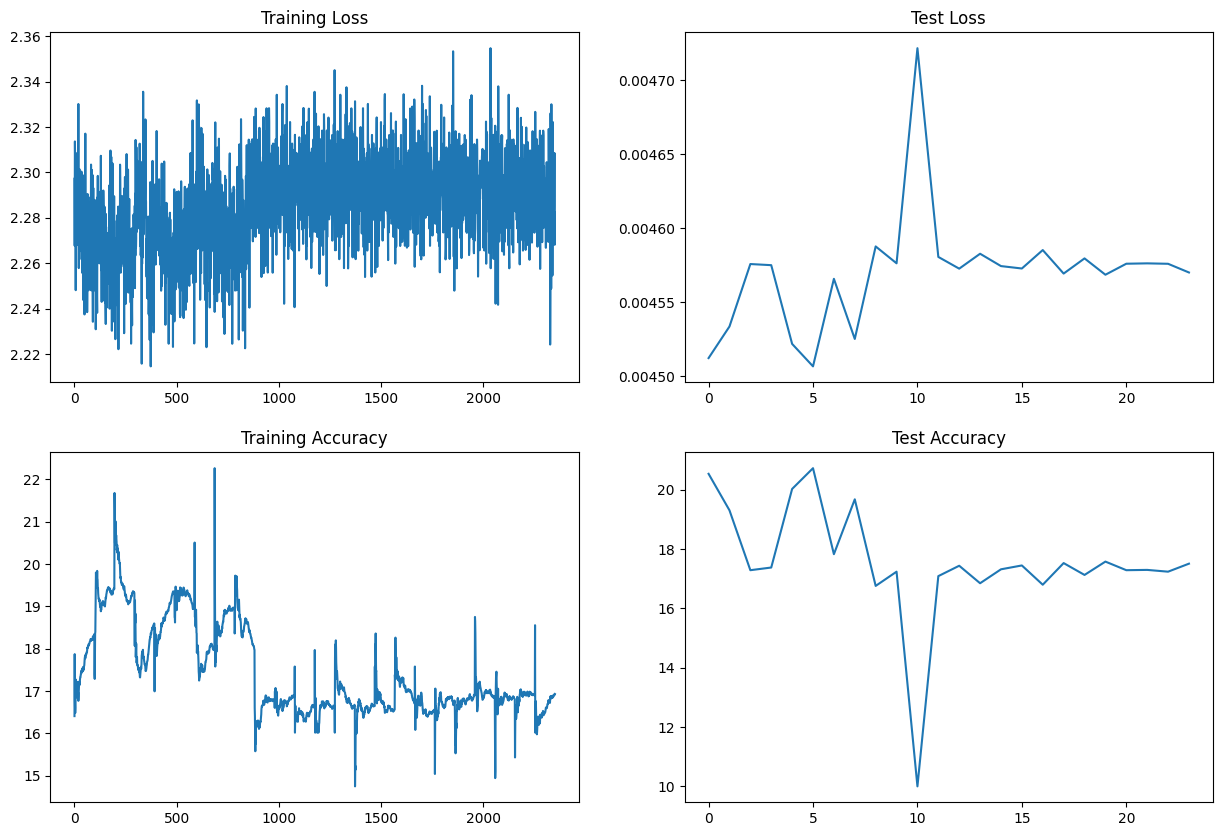

In [ ]:
helpers.plot_metrics(train_acc, train_losses, test_acc, test_losses)